# Least Squares GAN (LSGAN)

## Theory

The LSGAN is a modification to the GAN architecture that changes the loss function for the discriminator from binary cross entropy to a least squares loss.

The motivation for this change is that the least squares loss will penalize generated images based on their distance from the decision boundary. This will provide a strong gradient signal for generated images that are very different or far from the existing data and address the problem of saturated loss.

In addition to avoiding loss saturation, the LSGAN also results in a more stable training process and the generation of higher quality and larger images than the traditional deep convolutional GAN.

Suppose we use the $a$-$b$ coding scheme for the discriminator, where $a$ and $b$ are the labels for fake data and real data, respectively.

$$\min_D V(D, G) = \frac{1}{2} \mathbb{E}_{\mathbf{x} \sim p_{data}(\mathbf{x})} [(D(\mathbf{x}) - b)^2] + \frac{1}{2} \mathbb{E}_{\mathbf{z} \sim p_{\mathbf{z}}(\mathbf{z})} [(D(G(\mathbf{z})) - a)^2]$$

$$\min_G V(D, G) = \frac{1}{2} \mathbb{E}_{\mathbf{z} \sim p_{\mathbf{z}}(\mathbf{z})} [(D(G(\mathbf{z})) - c)^2]$$

where $c$ denotes the value that G wants D to believe for fake data.


## Advantages and Limitations

+ Improve the problem of vanishing gradients and loss saturation.

## References

Xudong Mao, et al., Least Squares Generative Adversarial Networks, ICCV 2017. 

In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True, source_url= 'http://yann.lecun.com/exdb/mnist/')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
mb_size = 128
X_dim = mnist.train.images.shape[1]
Z_dim = 100
h_dim = 128

lr = 1e-3
d_steps = 3

+ Initialization

In [4]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [5]:
X = tf.placeholder(tf.float32, shape=[None, X_dim])

D_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

D_W2 = tf.Variable(xavier_init([h_dim, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

G_W1 = tf.Variable(xavier_init([Z_dim, h_dim]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

G_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

+ Latent variable $z$ can sample from any distributions, e.g., uniform distribution or normal distribution.

In [6]:
def sample_Z(m, n):
    
    return np.random.uniform(-1., 1., size=[m, n])

+ Generator $G$ and Discriminator $D$ are two networks, e.g., ConvNets or Multi-Layer Perceptrons (MLP). Here, Two-Layer Full-Connected Forward Feedback NN.

In [7]:
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)
    
    return G_prob

def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    
    return D_logit

In [8]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [9]:
G_sample = generator(Z)

D_real = discriminator(X)
D_fake = discriminator(G_sample)

+ Loss functions

Here, $b = 1$, $a = 0$, $c = 1$. Those values is not the only valid values, though. The authors of LSGAN provides some theory that optimizing the above loss is the same as minimizing Pearson $\chi^2$ divergence, if $b - c = 1$ and $b - a = 2$. Hence, choosing $a = -1$, $b = 1$, $c = 0$ is equally valid.

In [10]:
D_loss = 0.5 * (tf.reduce_mean((D_real - 1)**2) + tf.reduce_mean(D_fake**2))
G_loss = 0.5 * tf.reduce_mean((D_fake - 1)**2)

D_solver = tf.train.AdamOptimizer(learning_rate=lr).minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer(learning_rate=lr).minimize(G_loss, var_list=theta_G)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


+ Here, $k = d\_steps$

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('GAN-LSGAN/'):
    os.makedirs('GAN-LSGAN/')
    
avg_costs = {'discriminator': [], 'generator': []}

i = 0

for it in range(50000):
    for _ in range(d_steps):
        X_mb, _ = mnist.train.next_batch(mb_size)
        Z_mb = sample_Z(mb_size, Z_dim)

        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: Z_mb})
        
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, Z_dim)})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D_loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print('\n')
        
        n_sample = 16
        
        samples = sess.run(G_sample, feed_dict={Z: sample_Z(n_sample, Z_dim)})

        fig = plot(samples)
        plt.savefig('GAN-LSGAN/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)
        
        avg_costs['discriminator'].append(D_loss_curr / n_sample)
        avg_costs['generator'].append(G_loss_curr / n_sample)

Iter: 0
D_loss: 0.409
G_loss: 1.119


Iter: 1000
D_loss: 0.0002144
G_loss: 0.5039


Iter: 2000
D_loss: 0.0004289
G_loss: 0.5067


Iter: 3000
D_loss: 0.003011
G_loss: 0.4922


Iter: 4000
D_loss: 0.003924
G_loss: 0.5063


Iter: 5000
D_loss: 0.01647
G_loss: 0.5231


Iter: 6000
D_loss: 0.02516
G_loss: 0.4497


Iter: 7000
D_loss: 0.04806
G_loss: 0.372


Iter: 8000
D_loss: 0.0373
G_loss: 0.4732


Iter: 9000
D_loss: 0.04736
G_loss: 0.4259


Iter: 10000
D_loss: 0.03749
G_loss: 0.3998


Iter: 11000
D_loss: 0.03957
G_loss: 0.4017


Iter: 12000
D_loss: 0.03996
G_loss: 0.4361


Iter: 13000
D_loss: 0.04707
G_loss: 0.406


Iter: 14000
D_loss: 0.05636
G_loss: 0.3848


Iter: 15000
D_loss: 0.05067
G_loss: 0.4565


Iter: 16000
D_loss: 0.05839
G_loss: 0.4063


Iter: 17000
D_loss: 0.05824
G_loss: 0.3955


Iter: 18000
D_loss: 0.06083
G_loss: 0.3688


Iter: 19000
D_loss: 0.0537
G_loss: 0.4953


Iter: 20000
D_loss: 0.05892
G_loss: 0.4241


Iter: 21000
D_loss: 0.05972
G_loss: 0.3726


Iter: 22000
D_loss: 0.07

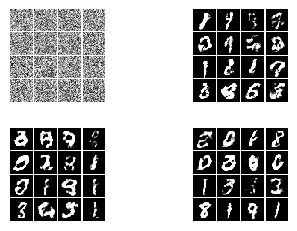

In [12]:
plt.figure()

ax = plt.subplot(221)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan1 = plt.imread('GAN-LSGAN/000.png')
plt.imshow(gan1, cmap='Greys_r')

ax = plt.subplot(222)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan2 = plt.imread('GAN-LSGAN/015.png')
plt.imshow(gan2, cmap='Greys_r')

ax = plt.subplot(223)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan3 = plt.imread('GAN-LSGAN/030.png')
plt.imshow(gan3, cmap='Greys_r')

ax = plt.subplot(224)
plt.axis('off')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
gan4 = plt.imread('GAN-LSGAN/045.png')
plt.imshow(gan4, cmap='Greys_r')

plt.show()

+ Performance estimation

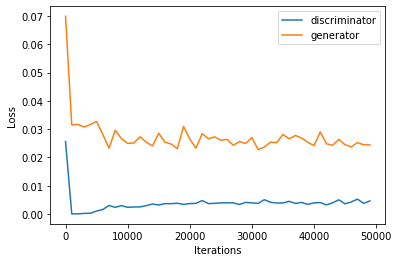

In [13]:
# plotting the learning curves
plt.figure()
plt.plot(np.arange(len(avg_costs['discriminator']))*1000, avg_costs['discriminator'], label='discriminator')
plt.plot(np.arange(len(avg_costs['generator']))*1000, avg_costs['generator'], label='generator')
plt.xlabel(r'Iterations')
plt.ylabel(r'Loss')
plt.legend()
plt.show()